# Designing 3D CNNs

The dimension of a CNN does not refer to the dimensions of the input but to the dimensions of the kernel stride.  
1D kernel moves only left-right (or up-down)  
2D kernel moves left-right and up-down  
3D kernel moves left-right, up-down and forward-backwards.   

Thus with a kernel of size (3,3,20) a 3D volume of size (150,150,20) could be processed. The present 2D CNN from pytorch and fastai could thus easily be adapted. However, small findings which only occur in a feq slices could disappear in the convolutions, so 3D CNNs with smaller kernels might be better.  



In [1]:
# default_exp models
# export 

import torchvision, torch
from torch import nn, Tensor, tensor
import torch.nn.functional as F
from warnings import warn

## Custom Modules

In [2]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

Somehow, in 3D CNNs, the input is not transfered to cuda. I believe something in the transforms is wrong. Until this is fixed, subcalssing _

is the workarround

In [3]:
# export
class Sequential_(nn.Sequential):
    "Similar to nn.Sequential, but copies input to cuda"
    def forward(self, input):
        for module in self:
            input = module(input.cuda())
        return input

## Custom 3D CNNs

In [4]:
# export
def resnet_3d(n_input, n_classes):
    return Sequential_(
        # 1st Conv Block
        nn.Conv3d(n_input, 64, kernel_size = (7,7,7), stride = (2, 2, 2), padding = (3, 3, 3), bias = True),
        nn.BatchNorm3d(64, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        nn.Dropout3d(),

        # 2nd Conv Block
        nn.Conv3d(64, 128, kernel_size = (5,5,5), stride = (2, 2, 2), padding = (2, 2, 2), bias = True),
        nn.BatchNorm3d(128, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        nn.Dropout3d(),
        
        # 3rd Conv Block
        nn.Conv3d(128, 256, kernel_size = (3,3,3), stride = (1, 1, 1), padding = (1, 1, 1), bias = True),
        nn.BatchNorm3d(256, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        nn.Dropout3d(),
        
        # 1st Res Block
        nn.Conv3d(256, 384, kernel_size = (3,3,3), stride = (1, 1, 1), padding = (1, 1, 1), bias = True),
        nn.BatchNorm3d(384, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        
        nn.Conv3d(384, 384, kernel_size = (3,3,3), stride = (1, 1, 1), padding = (1, 1, 1), bias = True),
        nn.BatchNorm3d(384, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        
        nn.Conv3d(384, 384, kernel_size = (3,3,3), stride = (1, 1, 1), padding = (1, 1, 1), bias = True),
        nn.BatchNorm3d(384, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        
        nn.Conv3d(384, 384, kernel_size = (3,3,3), stride = (1, 1, 1), padding = (1, 1, 1), bias = True),
        nn.BatchNorm3d(384, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        nn.ReLU(),
        nn.Dropout3d(),
                
        nn.AdaptiveAvgPool3d(1),
        nn.Flatten(),
        nn.Linear(384, n_classes), 
        nn.Softmax(dim = 1))

In [5]:
import fastai.vision.models

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(20, 128, kernel_size=11, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.AvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.softmax =  nn.LogSoftmax(dim=1)
        self.flatten = Flatten()

    def forward(self, x):
        if x.device.type == 'cpu': x = x.cuda()
        out = self.layer1(x)
   #     print(out.shape)
        out = self.layer2(out)
   #     print(out.shape)
        out = self.AvgPool(out)
  #      print(out.shape)
        out = self.flatten(out)
  #      print(out.shape)
        out = self.fc1(out)
 #       print(out.shape)
        out = self.fc2(out)
        out = self.softmax(out)
        # print(out.shape)
        return out

## Custon 3D UNets

In [7]:
# export

# copied from who????

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = Sequential_(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = Sequential_(
            nn.MaxPool3d(kernel_size = (2, 2, 2)),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):

        x1 = self.up(x1)
        # input is CHW
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2, 
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
            
    def forward(self, x):
        return self.conv(x)

In [8]:
# export
class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, trilinear=False):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.trilinear = trilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if trilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, trilinear)
        self.up2 = Up(512, 256 // factor, trilinear)
        self.up3 = Up(256, 128 // factor, trilinear)
        self.up4 = Up(128, 64, trilinear)
        self.outc = OutConv(64, n_classes)
       

    def forward(self, x):
#        print('x:', x.shape)
        x1 = self.inc(x)
#        print('x1:', x1.shape)
        x2 = self.down1(x1)
#        print('x2:', x2.shape)
        x3 = self.down2(x2)
#        print('x3:', x3.shape)
        x4 = self.down3(x3)
#        print('x4:', x4.shape)
        x5 = self.down4(x4)
#        print('x5:', x5.shape)

        x = self.up1(x5, x4)
#        print('x:', x.shape)
        x = self.up2(x, x3)
#        print('x:', x.shape)
        x = self.up3(x, x2)
#        print('x:', x.shape)
        x = self.up4(x, x1)
#        print('x:', x.shape)
        logits = self.outc(x)
#        print(logits.shape)
        return logits

## Custom Loss functions

In [9]:
# export
class DiceLossBinary():
    
    """
    Simple DICE loss as described in: 
        https://arxiv.org/pdf/1911.02855.pdf    
    
    Computes the Sørensen–Dice loss. Larger is better. 
    Note that PyTorch optimizers minimize a loss. So the loss is subtracted from 1. 
    
    Args:
        targ:    A tensor of shape [B, 1, D, H, W].
        pred:    A tensor of shape [B, 1, D, H, W]. Corresponds to
                 the raw output or logits of the model.
        method:  The method, how the DICE score should be calcualted. 
                    "simple"   = standard DICE loss
                    "miletari" = squared denominator for faster convergence
                    "tversky"  = variant of the DICE loss which allows to weight FP vs FN. 
        alpha, beta: weights for FP and FN for "tversky" loss, if both values are 0.5 the 
                 "tversky" loss corresponds to the "simple" DICE loss
        smooth:  Added smoothing factor. 
        eps: added to the denominator for numerical stability (acoid division by 0).
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    
    def __init__(self, method = 'miletari', alpha = 0.5, beta = 0.5, eps = 1e-7, smooth = 1.) -> None:
        self.method = method 
        self.alpha = alpha 
        self.beta = beta 
        self.eps = eps
        self.smooth = smooth
    
    def __call__(self, input: Tensor, target: Tensor) -> Tensor:
        if input.min() < 0 or input.max() > 1: 
            warn("Input is not in range between 0 and 1 but the loss will work better with input in that range. Consider rescaling your input. ")
           
        dims = (0,) + tuple(range(2, target.ndim))

        if self.method == 'simple':
            numerator  = torch.sum(input * target, dims) + self.smooth
            denominator  = torch.sum(input + target, dims) + self.smooth
            dice_loss = (2. * numerator / (denominator + self.eps))

        elif self.method == 'miletari':  
            numerator  = torch.sum(input * target, dims) + self.smooth
            denominator  = torch.sum(input**2 + target**2, dims) + self.smooth
            dice_loss = (2. * numerator / (denominator + self.eps))

        elif self.method == 'tversky':
            numerator  = torch.sum(input * target, dims) + self.smooth
            fps = torch.sum(input * (1 - target), dims)
            fns = torch.sum((1 - input) * target, dims)

            denominator  = numerator + self.alpha*fps + self.beta*fns + self.smooth
            dice_loss = (2. * numerator / (denominator + self.eps))
            
        else: 
            raise NotImplementedError('The specified type of DICE loss is not implemented')

        return 1-dice_loss 

Implementing the MCC score as loss function:  


$$\frac{ 
        \sum_{i}^{n} p_{ i }g_{ i } * \sum_{i}^{n}  1-p_{ i } 1-g_{ i } +
        \sum_{i}^{n}  1-p_{ i } g_{ i } * \sum_{i}^{n}  p_{ i } 1-g_{ i }}{ \sqrt{ 
        (\sum_{i}^{n}  p_{ i } g_{ i } + \sum_{i}^{n}  1-p_{ i } g_{ i }) * 
        (\sum_{i}^{n}  p_{ i } g_{ i } + \sum_{i}^{n} p_{ i } 1-g_{ i }) *  
        (\sum_{i}^{n}  1-p_{ i } g_{ i } + \sum_{i}^{n} 1-p_{ i } 1-g_{ i }) * 
        (\sum_{i}^{n}  p_{ i } 1-g_{ i } + \sum_{i}^{n} 1-p_{ i } 1-g_{ i }) 
     } }$$

where p_i is the prediction for pixel i and g_i the corresponding ground truth pixel and gamma is the smoothing factor.
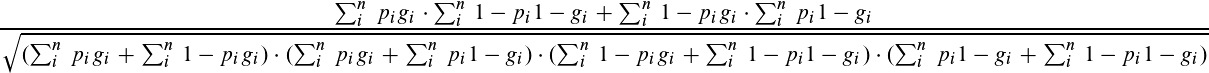

In [10]:
# export
class MCCLossBinary(DiceLossBinary):
    
    """
    Computes the MCC loss. 
    
    From Wikipedia (https://en.wikipedia.org/wiki/Matthews_correlation_coefficient):
        > The coefficient takes into account true and false positives and negatives and is generally 
        > regarded as a balanced measure which can be used even if the classes are of very different sizes
        > The MCC is in essence a correlation coefficient between the observed 
        > and predicted binary classifications; it returns a value between −1 and +1. 
        > A coefficient of +1 represents a perfect prediction, 0 no better than random prediction
        > and −1 indicates total disagreement between prediction and observation    
    
    For this loss to work best, the input should be in range 0-1, e.g. enforced through a sigmoid or softmax. 
    Note that PyTorch optimizers minimize a loss. So the loss is subtracted from 1. 

    Latex formula: 
    \frac{ 
        \Sum{ i }{ n }{ p_{ i } g_{ i }} * \Sum{ i }{ n }{ 1-p_{ i } 1-g_{ i }} +
        \Sum{ i }{ n }{ 1-p_{ i } g_{ i }} * \Sum{ i }{ n }{ p_{ i } 1-g_{ i }} }

    { \sqrt{ 
        (\Sum{ i }{ n }{ p_{ i } g_{ i }} + \Sum{ i }{ n }{ 1-p_{ i } g_{ i }}) * 
        (\Sum{ i }{ n }{ p_{ i } g_{ i }} + \Sum{ i }{ n }{ p_{ i } 1-g_{ i }}) *  
        (\Sum{ i }{ n }{ 1-p_{ i } g_{ i }} + \Sum{ i }{ n }{ 1-p_{ i } 1-g_{ i }}) * 
        (\Sum{ i }{ n }{ p_{ i } 1-g_{ i }} + \Sum{ i }{ n }{ 1-p_{ i } 1-g_{ i }}) 
     } }
    
    
    Args:
        input:   A tensor of shape [B, 1, D, H, W]. Predictions. 
        target:  A tensor of shape [B, 1, D, H, W]. Ground truth. 
        smooth:  Smoothing factor, default is 1. Inherited from DiceLossBinary base class 
        eps:     Added for numerical stability.
    Returns:
        mmc_loss: loss based on Matthews correlation coefficient
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def __call__(self, input: Tensor, target: Tensor) -> Tensor:         
        return self.compute_loss(input, target)
    
    def activation(self, input):
        return torch.sigmoid(input)
       
    def compute_loss(self, input: Tensor, target: Tensor):
        
        dims = (0,) + tuple(range(2, target.ndim))
        
        tps = torch.sum(self.activation(input) * target, dims) 
        fps = torch.sum(self.activation(input) * (1 - target), dims)
        fns = torch.sum((1 - self.activation(input)) * target, dims)
        tns = torch.sum((1 - self.activation(input)) * (1-target), dims)
            
        numerator = (tps * tns - fps * fns) + self.smooth 
        denominator =  ((tps + fps) * (tps + fns) * (fps + tns) * (tns + fns) + self.eps)**0.5 + self.smooth
        
        mcc_loss = numerator / (denominator)
        
        return 1-mcc_loss

In [11]:
i = torch.randn(5,1,2,25,25).sigmoid()
t = torch.randn(5,1,2,25,25).sigmoid().round()

MCCLossBinary()(i, t)

tensor([1.0001])

In [12]:
#export
class MCCLossMulti(MCCLossBinary):
    
    """
    Computes the MCC loss for a multilabel target. Basically the same as `MCCLossBinary` 
    but one hot encodes the target before computation. 
    
    Args:
        num_features: Number of different features in y. 
                 Must correspond to the maximum number of overall features in the whole dataset.
        input:   A tensor of shape [B, C, D, H, W], where the `n_classes` should correspond to C.
        target:  A tensor of shape [B, 1, D, H, W]. Ground truth. 
        weights: Either a str: 'auto' for autocalculation, None or a list/tuple of soecified weights
        smooth:  Smoothing factor, default is 1. Inherited from DiceLossBinary base class 
        eps:     Added for numerical stability.
        n_classes: number of classes to predict
    Returns:
        mmc_loss: loss based on Matthews correlation coefficient
    
    """
    def __init__(self, n_classes, weights=None, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights
        self.n_classes = n_classes
        
    def __call__(self, input: Tensor, target: Tensor) -> Tensor:
        
        self.get_weights(input)
        target = self.to_one_hot(target)

        return torch.mean(super().__call__(input, target)*self.weights)
    
    def get_weights(self, target):
        if self.weights == 'auto': 
            "estimates weights from the percentage distribution of a finding."
            dims = (0,) + tuple(range(2, target.ndim))
            self.weights = 1/torch.mean(target, dims)
        elif self.weights == None: 
            self.weights = 1.
        elif isinstance(self.weights, (tuple, list)):
            self.weights = tensor(self.weights)
    
    def make_binary(self, t, set_to_one):
        return (t == set_to_one).float()
  
    def to_one_hot(self, target:Tensor):
        target = target.squeeze(1).long() # remove the solitary color channel (if there is one) and set type to int64
        one_hot = [self.make_binary(target, set_to_one=i) for i in range(0, self.n_classes)]
    
        return torch.stack(one_hot, 1)
    
    def activation(self, input): 
        return F.softmax(input, 1) 

In [13]:
i = torch.randn(5,5,2,25,25)
t = torch.randint(0, 5, (5,1,2,25,25))

MCCLossMulti(5)(i, t)

tensor(0.9953)

# Custom metrics

In [14]:
# export
class MCCScore(MCCLossMulti):
    def __init__(self, n_classes = None, thres = 0.5, **kwargs):
        super().__init__(n_classes, **kwargs)
        
        self.n_classes = 1 if n_classes is None else n_classes
        self.thres = thres
    
    def __call__(self, input:Tensor , target: Tensor):
        if self.n_classes is not None: 
            target = self.to_one_hot(target)
            
            return 1-torch.mean(super().__call__(input, target))
        
    def activation(self, input): 
        return (input > self.thres).float()

In [15]:
MCCScore()(i, t)

tensor(-0.0050)

# Schätzung der TP, TN, FP, FN durch Regression

Um den Sensitivität und Spezifität berechen zu können müssen zuerst die TP, FP, TN und FN erechnet werden. 
Allerdings ist es auch Möglich die Sensitivität und Spezifität durch eine logistische Regression zu ermitteln (https://doi.org/10.1016/0895-4356(92)90180-u). 
Die log odds von Sensitivität und Spezifität können als folgende Funktion dargestellt werden:


$$ logit Pr(Y=1 | X) = \alpha + \sum_{k=1}^{K} \beta_{k}X_{k}$$

Die Schäzung der logit Sensitivität und logit Spezifität geschieht aus $(1...k)$ Variablen mit ihren entsprechenden Betacoeffizienten, wobei eine dieser Variablen dem Goldstandard entspricht. 

Die Ermittlung der Sensitivität ist daraufhin: 
$$\frac{1}{1+exp(-(\alpha+\sum_{k=1}^{K}\beta_{k}X_{k})} \quad \textrm{wobei} \quad X_{k}=1$$


Die Ermittlung der Spezifität ist ähnlich: 
$$1-(\frac{1}{1+exp(-(\alpha+\sum_{k=1}^{K}\beta_{k}X_{k}}) \quad \textrm{wobei} \quad X_{k}=0$$


von hier aus können Rückschlüsse auf die TP und TN gezogen werden durch: 

$$TP = Sens * P \quad \textrm{wobei} \quad P = \sum_{k=1}^{K} X_{k} \quad \textrm{fuer} \quad X=1$$

$$TN = Spec * N \quad \textrm{wobei} \quad N = \sum_{k=1}^{K} X_{k} \quad \textrm{fuer} \quad X_{k}=0$$

$$FN = (1-Sens) * P \quad \textrm{wobei} \quad P = \sum_{k=1}^{K} X_{k} \quad \textrm{fuer} \quad X_{k}=1$$

$$FP = (1-Spec) * N \quad \textrm{wobei} \quad N = \sum_{k=1}^{K} X_{k} \quad \textrm{fuer} \quad X_{k}=0$$


Wenn $X$ in $(0...1)$ dann kann $N = \sum_{k=1}^{K} 1-X_{k} \quad \textrm{fuer} \quad X=1$

Implementation des Verfahrens in Pytorch: 

In [344]:
x_data = torch.randn(1000, 1).sigmoid().round()
y_data = torch.randn(1000, 1).sigmoid().round()

Funktion für die Errechnung von Sensitivität und Spezifität durch eine Konfusionsmatrix

In [345]:
def cm(input, target): 
    tps = torch.sum(input * target) 
    fps = torch.sum(input * (1 - target))
    fns = torch.sum((1 - input) * target)
    tns = torch.sum((1 - input) * (1-target))
    
    sen = tps / (tps + fns)
    spec = tns /(tns + fps)
    
    return sen, spec

Lineares Regressionsmodell

In [349]:
class LinearRegression(torch.nn.Module):    
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(2, 1)    
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
def lin_reg(x, y):
    model = LinearRegression()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    x = torch.cat((x, y), dim = 1)

    for epoch in range(10000):
        model.train()
        optimizer.zero_grad()    # Forward pass
        y_pred = model(x)    # Compute Loss
        loss = criterion(y_pred, y)    # Backward pass
        loss.backward()
        optimizer.step()
        
    return model(x)

def sen_spe(pred, x_data):
    sen = 1/torch.exp(1+torch.mean(-pred[x_data == 0]))
    spe = 1-1/torch.exp(1+torch.mean(-pred[x_data == 0]))
    return sen, spe

In [351]:
p = lin_reg(x_data, y_data)
print(cm(x_data, y_data))
sen_spe(p, x_data)

(tensor(0.4785), tensor(0.5000))


(tensor(0.6368, grad_fn=<MulBackward0>),
 tensor(0.3632, grad_fn=<RsubBackward1>))